In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install PySastrawi

In [ ]:
import nltk

# Tokenizing
nltk.download('punkt')
# Stopwords removal
nltk.download('stopwords')
# Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

print('Completed')

Completed


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

# Load Data

Text Data (feedback & summary)

In [ ]:
file_path = "/content/drive/MyDrive/CAPSTONE/Dataset/unsuper summarize/successful_df.csv"
df = pd.read_csv(file_path)
df

,text,summary
0,"Leko merupakan resto penyetan khas jawa timur. Kami memesan empal penyet Dan nasi goreng bakso.Empal penyetnya empuk, bumbunya cukup terasa, sambalnya enak dan mantap sekali, hanya sayang dikasih ...",Leko merupakan resto penyetan khas jawa timur.
1,Bukber sama temen2 disini aku pesen yg Ayam Bakar Penyet. Bumbu ayam nya berasa bgt manis trus juga daging nya gak keras. Walaupun keliatan overcook tapi ngga ada rasa pait. Buat sambelnya aku suk...,Buat sambelnya aku suka karena gak begitu pedes yg cetar pokonya bikin makan jadi lahap deh.
2,"Menu yang saya pesan Nasi Goreng Teri Medan @Rp40.000.Rasanya sendiri lumayan enak, ga terlalu asin, gurihnya pas. Agak terlalu berminyak dikit tapi masih ok.Servicenya sendiri ramah, tempatnya ju...","Menu yang saya pesan Nasi Goreng Teri Medan @Rp40.000.Rasanya sendiri lumayan enak, ga terlalu asin, gurihnya pas."
3,Makanan indonesia dengan segala macem sambel tinggal pilih aja mau yg mana.Liat menunya lumayan banyak juga yg daging sapi. Tapi akhirnya ga ada order sapi wkwk.Menu yg diorder :- Nasi Goreng Teri...,Tahunya garing kulit dalamnya lumayan banyak isiannya.Suasananya lumayan oke lah.Ukurannya besar juga.Bisa buat berdua ini porsinya.
4,"Warung leko mah ud gausa diraguin lagi ya, rata2 masakannya enak semua. Pesen iga dan empal penyetnya. Enak pol. Dagingnya empuk, sambelnya juga maknyus, bisa request tingkat kepedasan. Jamur gore...","Jamur goreng tepungnya juga jgn lupa pesen, endul."
...,...,...
1968,"Hmm, enak banget makan sup asparagus jam segini. Udah buka lho! 😱.Enak lho sup asparagus di Bubur Kwang tung ini, asparagus, ga encer, asparagusnya juga fresh. Apalagi mimin tau manfaat asparagus ...",Apalagi mimin tau manfaat asparagus buat kesehatan tuh banyak banget!
1969,"Dulu saya perna ke bubur kwang tung yg di pecenongan tapi saking uda lamanya, uda lupa rasanya. Nah kali ini saya nyobain yg di cabang senopati. \n Tempatnya terbilang bagus utk resto bubur. Disin...","Dulu saya perna ke bubur kwang tung yg di pecenongan tapi saking uda lamanya, uda lupa rasanya."
1970,Ku menemukan bubur enak lagi yeay! Ternyata bukanya sampe jam 12 malem. Pilihan tepat bagi jiwa jiwa kelaparan di malam hari. Fuh fuh fuh. Betapa bahagia lagi ketika nyobain rasanya yang mantap su...,Ku menemukan bubur enak lagi yeay!Pilihan tepat bagi jiwa jiwa kelaparan di malam hari.
1971,"Berhubung lagi bingun mau makan apa, akhirnya gw gojekin bubur kwangtung ini.. Lagi gak pgn yg aneh2, jdnya gw psn bubur polos dgn cakwe dan cumi cabe garam. Untuk buburnya sendiri walopun blm dik...","Berhubung lagi bingun mau makan apa, akhirnya gw gojekin bubur kwangtung ini.. Lagi gak pgn yg aneh2, jdnya gw psn bubur polos dgn cakwe dan cumi cabe garam."


ID Stopword

In [ ]:
id_stopword_dict = pd.read_csv('/content/drive/MyDrive/CAPSTONE/Dataset/text-sum-preprocessing/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

In [ ]:
print("Shape: ", id_stopword_dict.shape)
id_stopword_dict

Shape:  (758, 1)


,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak
...,...
753,wong
754,yaitu
755,yakin
756,yakni


# Preprocessing

Drop duplicates and NA values

In [ ]:
df.drop_duplicates(subset=['text'],inplace=True)
df.dropna(axis=0,inplace=True)
df

,text,summary
0,"Leko merupakan resto penyetan khas jawa timur. Kami memesan empal penyet Dan nasi goreng bakso.Empal penyetnya empuk, bumbunya cukup terasa, sambalnya enak dan mantap sekali, hanya sayang dikasih ...",Leko merupakan resto penyetan khas jawa timur.
1,Bukber sama temen2 disini aku pesen yg Ayam Bakar Penyet. Bumbu ayam nya berasa bgt manis trus juga daging nya gak keras. Walaupun keliatan overcook tapi ngga ada rasa pait. Buat sambelnya aku suk...,Buat sambelnya aku suka karena gak begitu pedes yg cetar pokonya bikin makan jadi lahap deh.
2,"Menu yang saya pesan Nasi Goreng Teri Medan @Rp40.000.Rasanya sendiri lumayan enak, ga terlalu asin, gurihnya pas. Agak terlalu berminyak dikit tapi masih ok.Servicenya sendiri ramah, tempatnya ju...","Menu yang saya pesan Nasi Goreng Teri Medan @Rp40.000.Rasanya sendiri lumayan enak, ga terlalu asin, gurihnya pas."
3,Makanan indonesia dengan segala macem sambel tinggal pilih aja mau yg mana.Liat menunya lumayan banyak juga yg daging sapi. Tapi akhirnya ga ada order sapi wkwk.Menu yg diorder :- Nasi Goreng Teri...,Tahunya garing kulit dalamnya lumayan banyak isiannya.Suasananya lumayan oke lah.Ukurannya besar juga.Bisa buat berdua ini porsinya.
4,"Warung leko mah ud gausa diraguin lagi ya, rata2 masakannya enak semua. Pesen iga dan empal penyetnya. Enak pol. Dagingnya empuk, sambelnya juga maknyus, bisa request tingkat kepedasan. Jamur gore...","Jamur goreng tepungnya juga jgn lupa pesen, endul."
...,...,...
1968,"Hmm, enak banget makan sup asparagus jam segini. Udah buka lho! 😱.Enak lho sup asparagus di Bubur Kwang tung ini, asparagus, ga encer, asparagusnya juga fresh. Apalagi mimin tau manfaat asparagus ...",Apalagi mimin tau manfaat asparagus buat kesehatan tuh banyak banget!
1969,"Dulu saya perna ke bubur kwang tung yg di pecenongan tapi saking uda lamanya, uda lupa rasanya. Nah kali ini saya nyobain yg di cabang senopati. \n Tempatnya terbilang bagus utk resto bubur. Disin...","Dulu saya perna ke bubur kwang tung yg di pecenongan tapi saking uda lamanya, uda lupa rasanya."
1970,Ku menemukan bubur enak lagi yeay! Ternyata bukanya sampe jam 12 malem. Pilihan tepat bagi jiwa jiwa kelaparan di malam hari. Fuh fuh fuh. Betapa bahagia lagi ketika nyobain rasanya yang mantap su...,Ku menemukan bubur enak lagi yeay!Pilihan tepat bagi jiwa jiwa kelaparan di malam hari.
1971,"Berhubung lagi bingun mau makan apa, akhirnya gw gojekin bubur kwangtung ini.. Lagi gak pgn yg aneh2, jdnya gw psn bubur polos dgn cakwe dan cumi cabe garam. Untuk buburnya sendiri walopun blm dik...","Berhubung lagi bingun mau makan apa, akhirnya gw gojekin bubur kwangtung ini.. Lagi gak pgn yg aneh2, jdnya gw psn bubur polos dgn cakwe dan cumi cabe garam."


Function for pre-processing

In [ ]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('\r',' ',text) # Remove every '\r'
    text = re.sub('(?i)rt',' ',text) # Remove every retweet symbol
    text = re.sub('@[^\s]+[ \t]','',text) # Remove every username
    text = re.sub('(?i)user','',text) # Remove every username
    text = re.sub('(?i)url',' ',text) # Remove every url
    text = re.sub(r'\\x..',' ',text) # Remove every emoji
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text) #Remove characters repeating more than twice

    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    #text = re.sub(r'\d+', ' ', text)
    return text

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = remove_unnecessary_char(text) # 1
    text = lowercase(text) # 2
    text = remove_nonaplhanumeric(text) # 3
    text = stemming(text) # 4
    text = remove_stopword(text) # 5
    return text

In [ ]:
df = df.applymap(preprocess)
df

,text,summary
0,leko rupa resto penyet khas jawa timur mes empal penyet nasi goreng bakso empal penyet empuk bumbu asa sambal enak mantap sayang kasih lalap dikit nasi goreng bakso so so aja nasi goreng minyak ma...,leko rupa resto penyet khas jawa timur
1,bukber temen2 sen yg ayam bakar penyet bumbu ayam nya asa bgt manis trus daging nya gak keras liat overcook ngga pait sambelnya suka gak pedes yg cetar poko bikin makan lahap deh suasana nya nyama...,sambelnya suka gak pedes yg cetar poko bikin makan lahap deh
2,menu pesan nasi goreng teri medan lumayan enak ga asin gurih pas minyak dikit ok servicenya ramah nyaman,menu pesan nasi goreng teri medan lumayan enak ga asin gurih pas
3,makan indonesia macem sambel tinggal pilih aja yg liat menu lumayan yg daging sapi ga order sapi wkwk menu yg order nasi goreng teri medan 38k puas kerupuk keliling piring porsi nampol dominan man...,garing kulit lumayan isi suasana lumayan oke ukur porsi
4,warung leko mah ud gausa diraguin ya rata2 masakan enak sen iga empal penyet enak pol daging empuk sambelnya maknyus request tingkat pedas jamur goreng tepung jgn lupa sen endul layan cepat ramah ...,jamur goreng tepung jgn lupa sen endul
...,...,...
1968,hmm enak banget makan sup asparagus jam gin udah buka lho enak lho sup asparagus bubur kwang tung asparagus ga encer asparagus fresh mimin tau manfaat asparagus sehat tuh banget harga ga mahal drp...,mimin tau manfaat asparagus sehat tuh banget
1969,perna bubur kwang tung yg pecenongan saking uda uda lupa kali nyobain yg cabang senopati bilang bagus utk resto bubur jual chinese food pesan 1 bubur ayam sen yg porsi 2 org krn mkn ber 2 bubur ke...,perna bubur kwang tung yg pecenongan saking uda uda lupa
1970,ku temu bubur enak yeay nyata buka sampe jam 12 malem pilih jiwa jiwa lapar malam fuh fuh fuh betapa bahagia nyobain mantap surantap coba menu sbb 1 bubur kepiting 65k saji mangkok kepiting utuh c...,ku temu bubur enak yeay pilih jiwa jiwa lapar malam
1971,hubung bingun makan gw gojekin bubur kwangtung gak pgn yg aneh2 jdnya gw psn bubur polos dgn cakwe cumi cabe garam bubur walopun blm kasih apa2 tuh udh gt jd gausah trlalu bnyk ngasih kecap asinn ...,hubung bingun makan gw gojekin bubur kwangtung gak pgn yg aneh2 jdnya gw psn bubur polos dgn cakwe cumi cabe garam


Drop empty rows

In [ ]:
df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)
df

,text,summary
0,leko rupa resto penyet khas jawa timur mes empal penyet nasi goreng bakso empal penyet empuk bumbu asa sambal enak mantap sayang kasih lalap dikit nasi goreng bakso so so aja nasi goreng minyak ma...,leko rupa resto penyet khas jawa timur
1,bukber temen2 sen yg ayam bakar penyet bumbu ayam nya asa bgt manis trus daging nya gak keras liat overcook ngga pait sambelnya suka gak pedes yg cetar poko bikin makan lahap deh suasana nya nyama...,sambelnya suka gak pedes yg cetar poko bikin makan lahap deh
2,menu pesan nasi goreng teri medan lumayan enak ga asin gurih pas minyak dikit ok servicenya ramah nyaman,menu pesan nasi goreng teri medan lumayan enak ga asin gurih pas
3,makan indonesia macem sambel tinggal pilih aja yg liat menu lumayan yg daging sapi ga order sapi wkwk menu yg order nasi goreng teri medan 38k puas kerupuk keliling piring porsi nampol dominan man...,garing kulit lumayan isi suasana lumayan oke ukur porsi
4,warung leko mah ud gausa diraguin ya rata2 masakan enak sen iga empal penyet enak pol daging empuk sambelnya maknyus request tingkat pedas jamur goreng tepung jgn lupa sen endul layan cepat ramah ...,jamur goreng tepung jgn lupa sen endul
...,...,...
1968,hmm enak banget makan sup asparagus jam gin udah buka lho enak lho sup asparagus bubur kwang tung asparagus ga encer asparagus fresh mimin tau manfaat asparagus sehat tuh banget harga ga mahal drp...,mimin tau manfaat asparagus sehat tuh banget
1969,perna bubur kwang tung yg pecenongan saking uda uda lupa kali nyobain yg cabang senopati bilang bagus utk resto bubur jual chinese food pesan 1 bubur ayam sen yg porsi 2 org krn mkn ber 2 bubur ke...,perna bubur kwang tung yg pecenongan saking uda uda lupa
1970,ku temu bubur enak yeay nyata buka sampe jam 12 malem pilih jiwa jiwa lapar malam fuh fuh fuh betapa bahagia nyobain mantap surantap coba menu sbb 1 bubur kepiting 65k saji mangkok kepiting utuh c...,ku temu bubur enak yeay pilih jiwa jiwa lapar malam
1971,hubung bingun makan gw gojekin bubur kwangtung gak pgn yg aneh2 jdnya gw psn bubur polos dgn cakwe cumi cabe garam bubur walopun blm kasih apa2 tuh udh gt jd gausah trlalu bnyk ngasih kecap asinn ...,hubung bingun makan gw gojekin bubur kwangtung gak pgn yg aneh2 jdnya gw psn bubur polos dgn cakwe cumi cabe garam


Distribution of sequences

Analisis panjang text dan summary untuk mendapatkan max length dari sequence

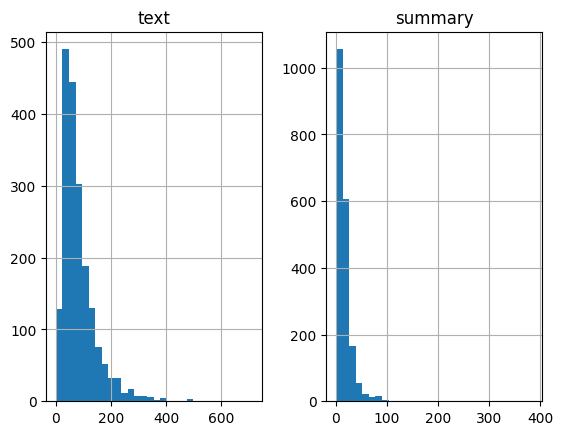

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split()))

for i in df['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in df['summary']:
    if(len(i.split()) <= 8):
        cnt=cnt+1
print(cnt/len(df['summary']))

0.2804123711340206


In [ ]:
cnt=0
for i in df['text']:
    if(len(i.split()) <= 100):
        cnt=cnt+1
print(cnt/len(df['text']))

0.7309278350515463


In [ ]:
max_text_len=30
max_summary_len=8

Sortir panjang text dan summary agar di bawah atau sama dengan max_text_len dan max_summary_len

In [ ]:
cleaned_text =np.array(df['text'])
cleaned_summary=np.array(df['summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df_new=pd.DataFrame({'text':short_text,'summary':short_summary}) # new dataframe to use

In [ ]:
# add the START and END special tokens at the beginning and end of the summary. Here, We have chosen sostok and eostok as START and END tokens
df_new['summary'] = df_new['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_new.head()

,text,summary
0,iga bakar the best suka banget daging super tender empuk trus kulit garing cabe sih nampol banget level 3 4,sostok suka banget daging super tender empuk eostok
1,salah resto iga penyet favorit kalo kangen makan indonesia porsi harga banding enak,sostok porsi harga banding eostok
2,gemar masakan jawa wajib banget coba resto masakan nya benar2 authentic harga reasonable live music jawa sayang bawa mobil sulit cari parkir,sostok gemar masakan jawa wajib banget coba resto eostok
3,name,sostok name eostok
4,makan kalap pilih banget bikin huh hah kepedesan favorite ayam setan oseng mercon instagenic banget outdoor kolam taman,sostok makan kalap pilih banget bikin huh hah kepedesan eostok


Split data dan menyeiapkan Tokenizer

In [ ]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df_new['text']), np.array(df_new['summary']),
                                       test_size=0.1, random_state=0, shuffle=True)

# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
# We will now build tokenizers for text and summary.

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

Rarewords

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 84.64566929133859
Total Coverage of rare words: 43.71878601613523


In [ ]:
print(cnt),print(tot_cnt)

860
1016


(None, None)

In [ ]:
print(freq),print(tot_freq)

1138
2603


(None, None)

Text Tokenizer

In [ ]:
# prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
print(x_voc)

157


In [ ]:
#prepare a tokenizer for reviews on training data

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

Summary Tokenizer

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 97.26775956284153
Total Coverage of rare words: 57.89473684210527


In [ ]:
print(cnt),print(tot_cnt)
print(freq),print(tot_freq)

356
366
495
855


(None, None)

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print(y_voc)

11


In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

#Model

Abstractive Text Summarization: the model simply selects and rearranges phrases or sentences that already exist in the original text

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.2,recurrent_dropout=0.2)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 30, 100)              15700     ['input_17[0][0]']            
                                                                                                  
 lstm_12 (LSTM)              [(None, 30, 300),            481200    ['embedding_6[0][0]']         
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                            

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Using EarlyStopping, model will stop training once the validatioin loss increases.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.80:
            print('\naccuracy > 80%')
            print('\nStop training model...')
            self.model.stop_training = True

CALLBACK = MyCallback()

In [ ]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=100,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/100
1/1 [==============================] - 17s 17s/step - loss: 2.4042 - accuracy: 0.0235 - val_loss: 2.2860 - val_accuracy: 0.6905
Epoch 2/100
1/1 [==============================] - 1s 514ms/step - loss: 2.2932 - accuracy: 0.6536 - val_loss: 2.0631 - val_accuracy: 0.6905
Epoch 3/100
1/1 [==============================] - 0s 468ms/step - loss: 2.0873 - accuracy: 0.6536 - val_loss: 1.1840 - val_accuracy: 0.6905
Epoch 4/100
1/1 [==============================] - 0s 489ms/step - loss: 1.3024 - accuracy: 0.6536 - val_loss: 1.5936 - val_accuracy: 0.7381
Epoch 5/100
1/1 [==============================] - 0s 465ms/step - loss: 1.6343 - accuracy: 0.7202 - val_loss: 0.9925 - val_accuracy: 0.6905
Epoch 6/100
1/1 [==============================] - 0s 468ms/step - loss: 1.1556 - accuracy: 0.6536 - val_loss: 1.2007 - val_accuracy: 0.5714
Epoch 7/100
1/1 [==============================] - 0s 461ms/step - loss: 1.1920 - accuracy: 0.5714 - val_loss: 0.9148 - val_accuracy: 0.6905
Epoch 8/100
1/

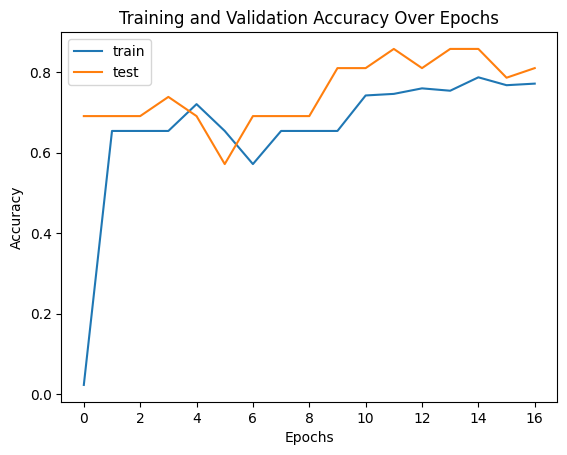

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.title('Training and Validation Accuracy Over Epochs')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.show()

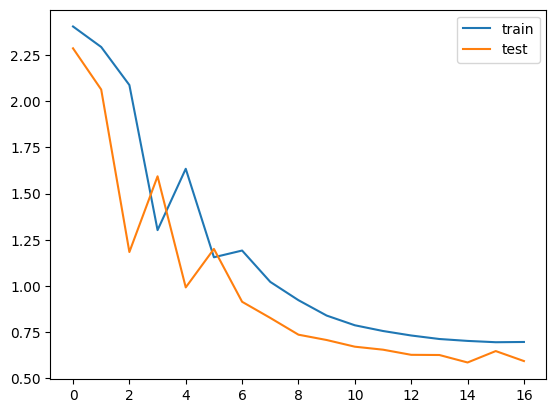

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model.save("text-sum.h5")

# Inference

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0, 10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: pilih makan menu soto ayam nya 2 pas 
Original summary: makan 
1/1 [==============================] - 0s 405ms/step
Predicted summary: 


Review: yg kenal lele legendaris lele nya crispy enak banget nasi uduk gak recommended banget nya sih pedes ya overall 
Original summary: nya 
1/1 [==============================] - 0s 20ms/step
Predicted summary: 


Review: rumah beli enak asa toppingnya porsi 1 porsi sih makan pesan 1 2 porsi aja nya enak ya ok ayam 
Original summary: nya enak ayam 
1/1 [==============================] - 0s 22ms/step
Predicted summary: 


Review: makan kuah gurih plus nambah kulit campur sen aja jam 
Original summary: makan 
1/1 [==============================] - 0s 22ms/step
Predicted summary: 


Review: mantep bumbu kacang bgt sayur fresh bgt ga manis 
Original summary: ga 
1/1 [==============================] - 0s 23ms/step
Predicted summary: 


Review: suka mie babi mie nya pas tekstur gak gak makan sen porsi 1 1 2 daging banget 
Original summary: bange